<a href="https://colab.research.google.com/github/samyzistec/TraductorColab/blob/master/Transformer_Nahuatl_Espanol_FromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0) Dependencias (ejecuta si hace falta)
```bash
%pip install sentencepiece sacrebleu gradio tqdm pyyaml pandas
# Opcional:
%pip install transformers accelerate datasets
%pip install torch-directml
# %pip install spacy && python -m spacy download es_core_news_sm
```


In [17]:
# 1) Rutas, semillas y splits
from pathlib import Path
import os, random, numpy as np, torch

BASE_DIR = Path(r"/content")
for p in [BASE_DIR, BASE_DIR/"salida", BASE_DIR/"checkpoints", BASE_DIR/"spm", BASE_DIR/"logs"]:
    p.mkdir(parents=True, exist_ok=True)

DATA_DIR = BASE_DIR / "salida"
CHECK_DIR = BASE_DIR / "checkpoints"
TOK_DIR = BASE_DIR / "spm"
LOG_DIR = BASE_DIR / "logs"

PARALLEL_JSONL = DATA_DIR / "/content/drive/MyDrive/Proyecto/parallel_ncx_es.jsonl"
assert PARALLEL_JSONL.exists(), f"No se encontró {PARALLEL_JSONL}. Coloca el corpus en esa ruta."

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

SPLIT_TRAIN = 0.8
SPLIT_DEV   = 0.1
MAX_SAMPLES = 0
MAX_LEN     = 128


In [18]:
# 2) Dispositivo
import torch
DEVICE = torch.device("cpu")
try:
    import torch_directml
    DEVICE = torch_directml.device()
    print("Usando DirectML (GPU AMD) si está disponible.")
except Exception as e:
    print("DirectML no disponible; usando CPU.\n", str(e))
print("DEVICE =", DEVICE)


DirectML no disponible; usando CPU.
 No module named 'torch_directml'
DEVICE = cpu


In [19]:
# 3) Carga de datos + segmentación
import json, re
from typing import List

def sent_split_es(text: str) -> List[str]:
    try:
        import spacy
        try: nlp = spacy.load("es_core_news_sm")
        except Exception:
            nlp = spacy.blank("es"); nlp.add_pipe("sentencizer")
        return [s.text.strip() for s in nlp(text).sents if s.text.strip()]
    except Exception:
        parts = re.split(r"(?<=[\.\?\!¡¿])\s+", text.strip())
        return [p.strip() for p in parts if p.strip()]

def sent_split_ncx(text: str) -> List[str]:
    parts = re.split(r"(?<=[\.\?\!])\s+", text.strip())
    return [p.strip() for p in parts if p.strip()]

pairs = []
with open(PARALLEL_JSONL, "r", encoding="utf-8") as f:
    for line in f:
        obj = json.loads(line)
        s = obj["src"].strip(); t = obj["tgt"].strip()
        if s and t: pairs.append((s, t, obj.get("libro",""), obj.get("capitulo",0), obj.get("versiculo",0)))
print(f"Pares cargados (verso): {len(pairs):,}")

expanded = []
for s, t, libro, cap, ver in pairs:
    ss = sent_split_ncx(s.lower()); tt = sent_split_es(t.lower())
    if 1 < len(ss) == len(tt) < 10:
        for i in range(len(ss)):
            expanded.append((ss[i], tt[i], libro, cap, f"{ver}.{i+1}"))
    else:
        expanded.append((s.lower(), t.lower(), libro, cap, ver))

if MAX_SAMPLES and MAX_SAMPLES>0:
    expanded = expanded[:MAX_SAMPLES]
print(f"Pares tras segmentación: {len(expanded):,}")


Pares cargados (verso): 5,357
Pares tras segmentación: 7,536


In [20]:
# 4) Splits
from math import floor
idx = list(range(len(expanded))); random.shuffle(idx)
n_tr = floor(len(idx)*SPLIT_TRAIN); n_de = floor(len(idx)*SPLIT_DEV)
def take(idxs): return [expanded[i] for i in idxs]
train_pairs = take(idx[:n_tr])
dev_pairs   = take(idx[n_tr:n_tr+n_de])
test_pairs  = take(idx[n_tr+n_de:])
print(f"Train={len(train_pairs):,} | Dev={len(dev_pairs):,} | Test={len(test_pairs):,}")


Train=6,028 | Dev=753 | Test=755


In [21]:
# 5) SentencePiece (Unigram, vocab compartido)
import sentencepiece as spm

VOCAB_SIZE = 10000
raw_corpus = (TOK_DIR / "spm_raw.txt")
with open(raw_corpus, "w", encoding="utf-8") as w:
    for s, t, *_ in train_pairs + dev_pairs:
        w.write(s + "\n"); w.write(t + "\n")

SPM_MODEL_PREFIX = str((TOK_DIR / "ncx_es_unigram").as_posix())
spm.SentencePieceTrainer.Train(
    input=str(raw_corpus),
    model_prefix=SPM_MODEL_PREFIX,
    vocab_size=VOCAB_SIZE,
    model_type="unigram",
    user_defined_symbols=["<pad>","<bos>","<eos>","<lang_ncx>","<lang_es>"],
    character_coverage=1.0,
    input_sentence_size=1000000,
    shuffle_input_sentence=True,
)

SPM_MODEL = TOK_DIR / "ncx_es_unigram.model"
SPM_VOCAB = TOK_DIR / "ncx_es_unigram.vocab"
assert SPM_MODEL.exists(), "No se generó el modelo SentencePiece."
print("Tokenizador entrenado →", SPM_MODEL)


Tokenizador entrenado → /content/spm/ncx_es_unigram.model


In [22]:
# 6) Tokenización helpers
sp = spm.SentencePieceProcessor(model_file=str(SPM_MODEL))

PAD_ID  = sp.piece_to_id("<pad>")
BOS_ID  = sp.piece_to_id("<bos>")
EOS_ID  = sp.piece_to_id("<eos>")
LNCX_ID = sp.piece_to_id("<lang_ncx>")
LES_ID  = sp.piece_to_id("<lang_es>")
VOCAB   = sp.get_piece_size()

def encode_with_lang(text, lang_tok_id):
    ids = sp.encode(text, out_type=int)
    return [BOS_ID, lang_tok_id] + ids + [EOS_ID]

def collate_batch(batch, pad_id=PAD_ID):
    src_lens = [len(b[0]) for b in batch]
    tgt_lens = [len(b[1]) for b in batch]
    max_src = min(max(src_lens), MAX_LEN)
    max_tgt = min(max(tgt_lens), MAX_LEN)
    def pad_seq(seq, L):
        seq = seq[:L]; return seq + [pad_id]*(L - len(seq))
    import torch
    src = torch.tensor([pad_seq(b[0], max_src) for b in batch], dtype=torch.long)
    tgt = torch.tensor([pad_seq(b[1], max_tgt) for b in batch], dtype=torch.long)
    return src, tgt


In [23]:
# 7) Dataset + bucketing
from torch.utils.data import Dataset, DataLoader
import random

class ParallelDataset(Dataset):
    def __init__(self, pairs, direction="ncx2es"):
        self.items = []
        for s, t, *_ in pairs:
            if direction=="ncx2es":
                self.items.append((encode_with_lang(s, LNCX_ID), encode_with_lang(t, LES_ID)))
            else:
                self.items.append((encode_with_lang(t, LES_ID), encode_with_lang(s, LNCX_ID)))
    def __len__(self): return len(self.items)
    def __getitem__(self, i): return self.items[i]

def make_loader(pairs, direction, batch_size=32, shuffle=True):
    ds = ParallelDataset(pairs, direction=direction)
    order = sorted(range(len(ds)), key=lambda i: len(ds.items[i][0]))
    if shuffle:
        B=50; buckets=[order[i::B] for i in range(B)]
        order=[i for b in buckets for i in random.sample(b, len(b))]
    class _Proxy(Dataset):
        def __len__(self): return len(order)
        def __getitem__(self, j): return ds.items[order[j]]
    return DataLoader(_Proxy(), batch_size=batch_size, collate_fn=collate_batch)


In [24]:
# 8) Transformer (Pre‑Norm) desde cero
import math
import torch, torch.nn as nn

DROPOUT = 0.1

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=2048):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(position*div_term)
        pe[:,1::2] = torch.cos(position*div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x): return x + self.pe[:, :x.size(1)]

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_k = d_model // n_heads; self.n = n_heads
        self.q = nn.Linear(d_model, d_model); self.k = nn.Linear(d_model, d_model)
        self.v = nn.Linear(d_model, d_model); self.o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, q, k, v, attn_mask=None, key_padding_mask=None):
        B,Lq,D = q.shape; B,Lk,_ = k.shape
        q = self.q(q).view(B,Lq,self.n,self.d_k).transpose(1,2)
        k = self.k(k).view(B,Lk,self.n,self.d_k).transpose(1,2)
        v = self.v(v).view(B,Lk,self.n,self.d_k).transpose(1,2)
        scores = torch.matmul(q, k.transpose(-2,-1))/math.sqrt(self.d_k)
        if attn_mask is not None:
            if attn_mask.dim()==2: scores = scores + attn_mask.unsqueeze(0).unsqueeze(0)
            elif attn_mask.dim()==4: scores = scores + attn_mask
        if key_padding_mask is not None:
            mask = key_padding_mask.unsqueeze(1).unsqueeze(2)
            scores = scores.masked_fill(mask, float('-inf'))
        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        out  = torch.matmul(attn, v).transpose(1,2).contiguous().view(B, Lq, D)
        return self.o(out)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(d_model, d_ff), nn.ReLU(), nn.Dropout(dropout), nn.Linear(d_ff, d_model))
    def forward(self, x): return self.net(x)

class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model); self.attn = MultiHeadAttention(d_model, n_heads, dropout); self.drop1 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model); self.ff   = FeedForward(d_model, d_ff, dropout);    self.drop2 = nn.Dropout(dropout)
    def forward(self, x, src_pad_mask):
        y = self.attn(self.norm1(x), self.norm1(x), self.norm1(x), key_padding_mask=src_pad_mask); x = x + self.drop1(y)
        y = self.ff(self.norm2(x)); x = x + self.drop2(y); return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model); self.self_attn = MultiHeadAttention(d_model, n_heads, dropout); self.drop1 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model); self.cross_attn = MultiHeadAttention(d_model, n_heads, dropout); self.drop2 = nn.Dropout(dropout)
        self.norm3 = nn.LayerNorm(d_model); self.ff = FeedForward(d_model, d_ff, dropout); self.drop3 = nn.Dropout(dropout)
    def forward(self, x, mem, tgt_pad_mask, tgt_causal_mask, mem_pad_mask):
        y = self.self_attn(self.norm1(x), self.norm1(x), self.norm1(x), attn_mask=tgt_causal_mask, key_padding_mask=tgt_pad_mask); x = x + self.drop1(y)
        y = self.cross_attn(self.norm2(x), mem, mem, key_padding_mask=mem_pad_mask); x = x + self.drop2(y)
        y = self.ff(self.norm3(x)); x = x + self.drop3(y); return x

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, d_ff, n_enc, n_dec, dropout=0.1, pad_id=0):
        super().__init__()
        self.pad_id = pad_id
        self.emb = nn.Embedding(vocab_size, d_model, padding_idx=pad_id)
        self.pos = PositionalEncoding(d_model)
        self.encoder = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_enc)])
        self.decoder = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_dec)])
        self.proj = nn.Linear(d_model, vocab_size)
    def make_pad_mask(self, seq): return seq.eq(self.pad_id)
    def make_causal_mask(self, L):
        mask = torch.triu(torch.ones(L, L, device=self.emb.weight.device), diagonal=1)
        return mask.masked_fill(mask==1, float('-inf'))
    def encode(self, src):
        src_pad = self.make_pad_mask(src); x = self.pos(self.emb(src))
        for layer in self.encoder: x = layer(x, src_pad)
        return x, src_pad
    def decode(self, tgt, mem, mem_pad):
        tgt_pad = self.make_pad_mask(tgt); x = self.pos(self.emb(tgt))
        causal = self.make_causal_mask(tgt.size(1)).unsqueeze(0).unsqueeze(0)
        for layer in self.decoder: x = layer(x, mem, tgt_pad, causal, mem_pad)
        return self.proj(x)
    def forward(self, src, tgt_in):
        mem, src_pad = self.encode(src); return self.decode(tgt_in, mem, src_pad)


In [25]:
!pip install sacrebleu

In [26]:
# 9) Loss (Label Smoothing), Noam y métricas
import torch.nn as nn, torch
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1, ignore_index=0):
        super().__init__(); self.ignore_index=ignore_index; self.confidence=1.0-smoothing; self.smoothing=smoothing; self.cls=classes
    def forward(self, pred, target):
        pred = pred.view(-1, pred.size(-1)); target = target.reshape(-1)
        log_probs = torch.log_softmax(pred, dim=-1)
        nll = -log_probs.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)
        smooth = -log_probs.mean(dim=-1)
        pad_mask = target.eq(self.ignore_index)
        loss = self.confidence*nll + self.smoothing*smooth
        return (loss.masked_fill(pad_mask,0).sum() / torch.clamp((~pad_mask).sum(), min=1))

class NoamWrapper:
    def __init__(self, optimizer, d_model, warmup=4000):
        self.opt=optimizer; self.d_model=d_model; self.warm=warmup; self.step_num=0
    def step(self):
        self.step_num += 1
        lr = (self.d_model ** -0.5) * min(self.step_num ** -0.5, self.step_num * (self.warm ** -1.5))
        for pg in self.opt.param_groups: pg['lr']=lr
        self.opt.step()
    def zero_grad(self): self.opt.zero_grad()
    @property
    def lr(self): return self.opt.param_groups[0]['lr']

try:
    from sacrebleu.metrics import BLEU, CHRF
    bleu = BLEU(force=True); chrf = CHRF(word_order=2)
except Exception as e:
    print("sacrebleu no disponible:", e); bleu=chrf=None


In [27]:
# 10) Eval/greedy + CFGs
import torch
def batch_to_device(b, device): return b[0].to(device), b[1].to(device)

def evaluate(model, loader, device):
    model.eval(); total=0.0; n=0
    with torch.no_grad():
        for src, tgt in loader:
            src, tgt = batch_to_device((src,tgt), device)
            logits = model(src, tgt[:, :-1])
            crit = LabelSmoothingLoss(VOCAB, 0.1, PAD_ID)
            loss = crit(logits, tgt[:,1:]); total += loss.item(); n += 1
    return total / max(n,1)

def ids_to_text(ids):
    ids = [i for i in ids if i not in (PAD_ID, BOS_ID)]
    if ids and ids[-1] == EOS_ID: ids = ids[:-1]
    return sp.decode(ids)

def translate_greedy(model, src_ids, max_len=MAX_LEN, tgt_lang_id=LES_ID):
    model.eval()
    src = torch.tensor([src_ids], dtype=torch.long, device=model.emb.weight.device)
    mem, src_pad = model.encode(src)
    ys = torch.tensor([[BOS_ID, tgt_lang_id]], dtype=torch.long, device=src.device)
    for _ in range(max_len):
        logits = model.decode(ys, mem, src_pad)
        nxt = logits[:,-1,:].argmax(dim=-1, keepdim=True)
        ys = torch.cat([ys, nxt], dim=1)
        if nxt.item() == EOS_ID: break
    return ys[0].tolist()

CFG_SMALL = dict(d_model=512, n_heads=8, d_ff=2048, n_enc=6, n_dec=6)
CFG_LIGHT = dict(d_model=256, n_heads=4, d_ff=1024, n_enc=4, n_dec=4)


In [28]:

# 10b) Logging CSV + Early Stopping + Resume
import csv, pathlib
from datetime import datetime

def ensure_logfile(direction):
    LOG_DIR.mkdir(parents=True, exist_ok=True)
    path = LOG_DIR / f"train_log_{direction}.csv"
    if not path.exists():
        with open(path, "w", encoding="utf-8", newline="") as w:
            csv.writer(w).writerow(["timestamp","direction","epoch","steps","lr","train_loss","dev_loss","dev_bleu","dev_chrf","best_so_far"])
    return path

def translate_greedy_dir(model, src_ids, direction="ncx2es", max_len=MAX_LEN):
    tgt_lang = LES_ID if direction=="ncx2es" else LNCX_ID
    return translate_greedy(model, src_ids, max_len=max_len, tgt_lang_id=tgt_lang)

def compute_dev_metrics(model, direction="ncx2es", max_samples=200):
    ds = ParallelDataset(dev_pairs, direction=direction)
    if len(ds) == 0: return (0.0, 0.0)
    up = min(len(ds), max_samples)
    refs, hyps = [], []
    for i in range(up):
        src_ids, tgt_ids = ds[i]
        out_ids = translate_greedy_dir(model, src_ids, direction=direction, max_len=MAX_LEN)
        refs.append([ids_to_text(tgt_ids)]); hyps.append(ids_to_text(out_ids))
    try:
        from sacrebleu.metrics import BLEU, CHRF
        bleu_val = BLEU(force=True).corpus_score(hyps, list(zip(*refs))).score
        chrf_val = CHRF(word_order=2).corpus_score(hyps, list(zip(*refs))).score
        return (bleu_val, chrf_val)
    except Exception:
        return (0.0, 0.0)

def save_checkpoint(model, save_prefix, d_model, n_heads, d_ff, n_enc, n_dec, pad_id, vocab, direction, epoch, noam_step=0):
    CHECK_DIR.mkdir(parents=True, exist_ok=True)
    path = (CHECK_DIR / f"{save_prefix}_best.pt").as_posix()
    torch.save({"model":model.state_dict(),
                "cfg":{"d_model":d_model,"n_heads":n_heads,"d_ff":d_ff,"n_enc":n_enc,"n_dec":n_dec,"pad_id":pad_id,"vocab":vocab},
                "meta":{"direction":direction,"epoch":epoch,"noam_step":noam_step,"spm_model":str(SPM_MODEL)}},
               path)
    return path

def train_direction(direction="ncx2es",
                    epochs=2, batch_size=32, grad_accum=1,
                    d_model=512, n_heads=8, d_ff=2048, n_enc=6, n_dec=6,
                    warmup=4000, save_prefix="scratch_ncx2es",
                    patience=3, dev_metric_samples=200, init_model=None, start_epoch=1):
    print(f"\n=== Entrenando dirección: {direction} ===")
    train_loader = make_loader(train_pairs, direction, batch_size=batch_size, shuffle=True)
    dev_loader   = make_loader(dev_pairs,   direction, batch_size=batch_size, shuffle=False)

    model = TransformerModel(VOCAB, d_model, n_heads, d_ff, n_enc, n_dec, DROPOUT, PAD_ID) if init_model is None else init_model
    model.to(DEVICE)

    opt = torch.optim.Adam(model.parameters(), betas=(0.9,0.98), eps=1e-9)
    noam = NoamWrapper(opt, d_model, warmup=warmup)
    crit = LabelSmoothingLoss(VOCAB, 0.1, PAD_ID)

    log_path = ensure_logfile(direction)
    best_dev_chrf = -1e9; epochs_no_improve = 0; best_path = None; global_step = 0

    for ep in range(start_epoch, start_epoch + epochs):
        model.train(); total=0.0; n=0; opt.zero_grad()
        for i, (src, tgt) in enumerate(train_loader, 1):
            src, tgt = src.to(DEVICE), tgt.to(DEVICE)
            logits = model(src, tgt[:, :-1])
            loss = crit(logits, tgt[:, 1:]) / grad_accum
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            if i % grad_accum == 0:
                noam.step(); noam.zero_grad()
            total += loss.item()*grad_accum; n += 1; global_step += 1
            if i % 100 == 0:
                print(f"ep{ep} step{i} lr={noam.lr:.6f} loss={total/max(n,1):.4f}")

        dev_loss = evaluate(model, dev_loader, DEVICE)
        dev_bleu, dev_chrf = compute_dev_metrics(model, direction=direction, max_samples=dev_metric_samples)
        print(f"[Ep {ep}] dev_loss={dev_loss:.4f} | BLEU={dev_bleu:.2f} | chrF++={dev_chrf:.2f}")

        with open(log_path, "a", encoding="utf-8", newline="") as w:
            csv.writer(w).writerow([datetime.utcnow().isoformat(), direction, ep, global_step,
                                    f"{noam.lr:.8f}", f"{total/max(n,1):.6f}", f"{dev_loss:.6f}",
                                    f"{dev_bleu:.4f}", f"{dev_chrf:.4f}", "yes" if dev_chrf>best_dev_chrf else "no"])

        if dev_chrf > best_dev_chrf:
            best_dev_chrf = dev_chrf
            best_path = save_checkpoint(model, save_prefix, d_model, n_heads, d_ff, n_enc, n_dec, PAD_ID, VOCAB, direction, ep, noam.step_num)
            print("Mejora en chrF++; guardado mejor modelo en", best_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"Sin mejora de chrF++ por {epochs_no_improve}/{patience} épocas")
            if epochs_no_improve >= patience:
                print("Early stopping activado."); break

    return best_path, best_dev_chrf

def load_for_resume(ckpt_path):
    data = torch.load(ckpt_path, map_location="cpu")
    cfg = data["cfg"]; meta = data.get("meta", {})
    model = TransformerModel(cfg["vocab"], cfg["d_model"], cfg["n_heads"], cfg["d_ff"], cfg["n_enc"], cfg["n_dec"], pad_id=cfg["pad_id"])
    model.load_state_dict(data["model"]); model.to(DEVICE)
    return model, cfg, meta


In [29]:
# 11) Entrenamiento (ambas direcciones)
EPOCHS = 2; BATCH = 32; ACCUM = 1; WARMUP = 4000
best_ncx2es, _ = train_direction("ncx2es", epochs=EPOCHS, batch_size=BATCH, grad_accum=ACCUM, warmup=WARMUP, save_prefix="scratch_ncx2es", **CFG_SMALL)
best_es2ncx, _ = train_direction("es2ncx", epochs=EPOCHS, batch_size=BATCH, grad_accum=ACCUM, warmup=WARMUP, save_prefix="scratch_es2ncx", **CFG_SMALL)
print("Mejores checkpoints:", best_ncx2es, best_es2ncx)



=== Entrenando dirección: ncx2es ===
ep1 step100 lr=0.000017 loss=8.1295
[Ep 1] dev_loss=6.0070 | BLEU=9.88 | chrF++=18.50
Mejora en chrF++; guardado mejor modelo en /content/checkpoints/scratch_ncx2es_best.pt


/tmp/ipython-input-1148275648.py:81: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  csv.writer(w).writerow([datetime.utcnow().isoformat(), direction, ep, global_step,


ep2 step100 lr=0.000050 loss=5.8533
[Ep 2] dev_loss=5.3903 | BLEU=17.68 | chrF++=21.46
Mejora en chrF++; guardado mejor modelo en /content/checkpoints/scratch_ncx2es_best.pt

=== Entrenando dirección: es2ncx ===
ep1 step100 lr=0.000017 loss=7.8956
[Ep 1] dev_loss=5.8099 | BLEU=19.92 | chrF++=17.89
Mejora en chrF++; guardado mejor modelo en /content/checkpoints/scratch_es2ncx_best.pt
ep2 step100 lr=0.000050 loss=5.7088
[Ep 2] dev_loss=5.2707 | BLEU=20.63 | chrF++=24.13
Mejora en chrF++; guardado mejor modelo en /content/checkpoints/scratch_es2ncx_best.pt
Mejores checkpoints: /content/checkpoints/scratch_ncx2es_best.pt /content/checkpoints/scratch_es2ncx_best.pt


In [30]:
# 12) Evaluación
from pathlib import Path
def load_model(path):
    data = torch.load(path, map_location="cpu")
    cfg = data["cfg"]
    model = TransformerModel(cfg["vocab"], cfg["d_model"], cfg["n_heads"], cfg["d_ff"], cfg["n_enc"], cfg["n_dec"], pad_id=cfg["pad_id"])
    model.load_state_dict(data["model"]); model.to(DEVICE); model.eval()
    return model

def eval_direction(best_path, direction="ncx2es", max_samples=200):
    if best_path is None or not Path(best_path).exists():
        print("Checkpoint no encontrado:", best_path); return
    model = load_model(best_path)
    ds = ParallelDataset(test_pairs, direction=direction)
    refs, hyps = [], []
    for i in range(min(len(ds), max_samples)):
        src_ids, tgt_ids = ds[i]
        out_ids = translate_greedy(model, src_ids, max_len=MAX_LEN, tgt_lang_id=(LES_ID if direction=='ncx2es' else LNCX_ID))
        refs.append([ids_to_text(tgt_ids)]); hyps.append(ids_to_text(out_ids))
    try:
        from sacrebleu.metrics import BLEU, CHRF
        print(direction, "BLEU:", BLEU(force=True).corpus_score(hyps, list(zip(*refs))))
        print(direction, "chrF++:", CHRF(word_order=2).corpus_score(hyps, list(zip(*refs))))
    except Exception as e:
        print("sacrebleu no disponible:", e)

eval_direction(best_ncx2es, "ncx2es")
eval_direction(best_es2ncx, "es2ncx")


ncx2es BLEU: BLEU = 17.45 39.1/19.8/14.2/10.1 (BP = 0.956 ratio = 0.957 hyp_len = 5144 ref_len = 5373)
ncx2es chrF++: chrF2++ = 21.33
es2ncx BLEU: BLEU = 17.27 33.7/18.6/14.1/10.1 (BP = 1.000 ratio = 1.211 hyp_len = 5081 ref_len = 4197)
es2ncx chrF++: chrF2++ = 24.02


In [31]:
# 13) UI Gradio
import gradio as gr, torch
def translate_beam(model, src_ids, beam=5, lp=0.7, max_len=MAX_LEN, tgt_lang_id=LES_ID):
    model.eval()
    device = model.emb.weight.device
    src = torch.tensor([src_ids], dtype=torch.long, device=device)
    mem, src_pad = model.encode(src)
    beams = [([BOS_ID, tgt_lang_id], 0.0)]; finished = []
    for _ in range(max_len):
        new_beams = []
        for seq, score in beams:
            if seq[-1] == EOS_ID:
                finished.append((seq, score)); continue
            ys = torch.tensor([seq], dtype=torch.long, device=device)
            logits = model.decode(ys, mem, src_pad)[:,-1,:].squeeze(0)
            logp = torch.log_softmax(logits, dim=-1).detach().cpu()
            topk = torch.topk(logp, beam).indices.tolist()
            for tok in topk:
                new_beams.append((seq+[tok], score+logp[tok].item()))
        beams = sorted(new_beams, key=lambda x: x[1]/((len(x[0])**lp)), reverse=True)[:beam]
        if not beams: break
    if not finished: finished = beams
    best = max(finished, key=lambda x: x[1]/((len(x[0])**lp)))
    return best[0]

BEST_NCX2ES = best_ncx2es if 'best_ncx2es' in globals() else None
BEST_ES2NCX = best_es2ncx if 'best_es2ncx' in globals() else None

def _load_model_(path):
    data = torch.load(path, map_location="cpu")
    cfg = data["cfg"]; m = TransformerModel(cfg["vocab"], cfg["d_model"], cfg["n_heads"], cfg["d_ff"], cfg["n_enc"], cfg["n_dec"], pad_id=cfg["pad_id"])
    m.load_state_dict(data["model"]); m.eval(); return m

def load_scratch(direction):
    from pathlib import Path
    path = BEST_NCX2ES if direction=="ncx2es" else BEST_ES2NCX
    if path is None or not Path(path).exists(): return None, f"Checkpoint no encontrado: {path}"
    return _load_model_(path), f"Cargado: {path}"

def infer_scratch(text, direction="ncx2es", beam=5):
    if not text.strip(): return ""
    model, msg = load_scratch(direction)
    lang_id = LES_ID if direction=="ncx2es" else LNCX_ID
    src_lang = LNCX_ID if direction=="ncx2es" else LES_ID
    src_ids = encode_with_lang(text.lower(), src_lang)
    out_ids = translate_beam(model, src_ids, beam=beam, tgt_lang_id=lang_id)
    return ids_to_text(out_ids)

with gr.Blocks() as demo:
    gr.Markdown("## Traductor (Transformer desde cero)")
    direction = gr.Radio(choices=["ncx2es","es2ncx"], value="ncx2es", label="Dirección")
    beam = gr.Slider(1, 10, step=1, value=5, label="Beam size")
    inp = gr.Textbox(lines=3, label="Texto de entrada")
    out = gr.Textbox(lines=3, label="Traducción")
    btn = gr.Button("Traducir")
    btn.click(fn=infer_scratch, inputs=[inp, direction, beam], outputs=[out])
print("Para lanzar la UI: demo.launch()")


Para lanzar la UI: demo.launch()


In [ ]:
demo.launch()

In [32]:
# 16) Matrices de confusión — utilidades (SPM y carácter)
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter

def _align_levenshtein(ref, hyp):
    m, n = len(ref), len(hyp)
    dp = [[0]*(n+1) for _ in range(m+1)]
    back = [[None]*(n+1) for _ in range(m+1)]
    for i in range(1, m+1):
        dp[i][0] = i; back[i][0] = 'D'
    for j in range(1, n+1):
        dp[0][j] = j; back[0][j] = 'I'
    for i in range(1, m+1):
        for j in range(1, n+1):
            cost = 0 if ref[i-1] == hyp[j-1] else 1
            opts = [
                (dp[i-1][j] + 1, 'D'),
                (dp[i][j-1] + 1, 'I'),
                (dp[i-1][j-1] + cost, 'M' if cost==0 else 'S')
            ]
            dp[i][j], back[i][j] = min(opts, key=lambda x: x[0])
    i, j = m, n
    a_ref, a_hyp = [], []
    while i>0 or j>0:
        op = back[i][j]
        if op == 'M' or op == 'S':
            a_ref.append(ref[i-1]); a_hyp.append(hyp[j-1]); i-=1; j-=1
        elif op == 'D':
            a_ref.append(ref[i-1]); a_hyp.append('<eps>'); i-=1
        elif op == 'I':
            a_ref.append('<eps>'); a_hyp.append(hyp[j-1]); j-=1
        else:
            break
    a_ref.reverse(); a_hyp.reverse()
    return a_ref, a_hyp

def _pieces_from_ids(ids):
    specials = {PAD_ID, BOS_ID, EOS_ID, LNCX_ID, LES_ID}
    return [sp.id_to_piece(i) for i in ids if i not in specials]

def _char_list(text):
    return [c for c in text.replace(" ", "")]

def _count_confusions(aligned_ref, aligned_hyp):
    cnt = Counter()
    for r, h in zip(aligned_ref, aligned_hyp):
        cnt[(r, h)] += 1
    return cnt

def _top_labels(counter, top_n=200, include_eps=True):
    from collections import Counter as C
    freq_ref = C()
    for (r, h), c in counter.items():
        freq_ref[r] += c
    labels = [tok for tok, _ in freq_ref.most_common(top_n)]
    other = "<other>"
    if "<eps>" in labels: labels.remove("<eps>")
    if include_eps and "<eps>" not in labels:
        labels = labels + ["<eps>"]
    if other not in labels:
        labels = labels + [other]

    freq_hyp = C()
    for (r, h), c in counter.items():
        freq_hyp[h] += c
    cols = [tok for tok, _ in freq_hyp.most_common(top_n)]
    if include_eps and "<eps>" not in cols:
        cols = cols + ["<eps>"]
    if other not in cols:
        cols = cols + [other]
    return labels, cols

def _matrix_from_counter(counter, rows, cols):
    idx = {t:i for i,t in enumerate(rows)}
    jdx = {t:j for j,t in enumerate(cols)}
    import numpy as np
    mat = np.zeros((len(rows), len(cols)), dtype=int)
    for (r,h), c in counter.items():
        rkey = r if r in idx else "<other>"
        hkey = h if h in jdx else "<other>"
        ri = idx.get(rkey, idx["<other>"])
        hj = jdx.get(hkey, jdx["<other>"])
        mat[ri, hj] += c
    return mat

def _save_confusion_outputs(mat, rows, cols, out_prefix):
    import pandas as pd, matplotlib.pyplot as plt, numpy as np, os
    os.makedirs(os.path.dirname(out_prefix), exist_ok=True)
    df = pd.DataFrame(mat, index=rows, columns=cols)
    df.to_csv(out_prefix + ".csv", encoding="utf-8")
    plt.figure(figsize=(10, 7))
    plt.imshow(mat, aspect="auto")
    plt.colorbar()
    plt.xticks(ticks=np.arange(len(cols)), labels=cols, rotation=90, fontsize=7)
    plt.yticks(ticks=np.arange(len(rows)), labels=rows, fontsize=7)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig(out_prefix + ".png", dpi=150)
    plt.close()

def _save_top_pairs(counter, out_csv, k=50):
    import pandas as pd, os
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    data = sorted([(*k_, v) for k_, v in counter.items() if k_[0] != k_[1]], key=lambda x: x[2], reverse=True)[:k]
    df = pd.DataFrame(data, columns=["ref", "hyp", "count"])
    df.to_csv(out_csv, index=False, encoding="utf-8")

def _build_sequences(level, ref_text, hyp_text, ref_ids=None, hyp_ids=None):
    if level == "spm":
        rseq = _pieces_from_ids(ref_ids) if ref_ids is not None else sp.encode(ref_text, out_type=str)
        hseq = _pieces_from_ids(hyp_ids) if hyp_ids is not None else sp.encode(hyp_text, out_type=str)
    elif level == "char":
        rseq = _char_list(ref_text); hseq = _char_list(hyp_text)
    else:
        raise ValueError("level debe ser 'spm' o 'char'")
    return rseq, hseq

def confusion_for_dataset(model, dataset, direction="ncx2es", level="spm", top_n=200, beam=5, max_samples=500, out_dir=None, tag="dev"):
    from tqdm import tqdm, trange
    cnt = Counter()
    N = min(len(dataset), max_samples)
    tgt_lang_id = LES_ID if direction == "ncx2es" else LNCX_ID
    for i in tqdm(range(N), desc=f"Confusion {tag} {direction} {level}"):
        src_ids, tgt_ids = dataset[i]
        out_ids = translate_beam(model, src_ids, beam=beam, tgt_lang_id=tgt_lang_id)
        ref_text = ids_to_text(tgt_ids); hyp_text = ids_to_text(out_ids)
        rseq, hseq = _build_sequences(level, ref_text, hyp_text, ref_ids=tgt_ids, hyp_ids=out_ids if level=="spm" else None)
        a_r, a_h = _align_levenshtein(rseq, hseq)
        cnt += _count_confusions(a_r, a_h)
    rows, cols = _top_labels(cnt, top_n=top_n, include_eps=True)
    mat = _matrix_from_counter(cnt, rows, cols)
    import os
    os.makedirs(out_dir, exist_ok=True)
    prefix = os.path.join(out_dir, f"confusion_{tag}_{direction}_{level}")
    _save_confusion_outputs(mat, rows, cols, prefix)
    _save_top_pairs(cnt, os.path.join(out_dir, f"top_pairs_{tag}_{direction}_{level}.csv"), k=50)
    return prefix


In [33]:
# 17) Ejecutar matrices de confusión (ambas direcciones, dev/test, SPM+char)
TOP_N = 200; BEAM = 5; MAX_SAMPLES = 500
OUT_DIR = (LOG_DIR / "analytics").as_posix()

from pathlib import Path

def load_model(path):
    data = torch.load(path, map_location="cpu")
    cfg = data["cfg"]
    model = TransformerModel(cfg["vocab"], cfg["d_model"], cfg["n_heads"], cfg["d_ff"], cfg["n_enc"], cfg["n_dec"], pad_id=cfg["pad_id"])
    model.load_state_dict(data["model"]); model.to(DEVICE); model.eval()
    return model

def _get_model_for(direction):
    try:
        if direction == "ncx2es" and 'best_ncx2es' in globals() and best_ncx2es:
            path = best_ncx2es
        elif direction == "es2ncx" and 'best_es2ncx' in globals() and best_es2ncx:
            path = best_es2ncx
        else:
            fname = "scratch_ncx2es_best.pt" if direction=="ncx2es" else "scratch_es2ncx_best.pt"
            path = (CHECK_DIR / fname).as_posix()
        print("Cargando", path)
        model = load_model(path)
        return model
    except Exception as e:
        print("No fue posible cargar el modelo:", e)
        return None

def run_confusions():
    sets = [("dev", dev_pairs), ("test", test_pairs)]
    dirs = ["ncx2es", "es2ncx"]
    levels = ["spm", "char"]
    for direction in dirs:
        model = _get_model_for(direction)
        if model is None:
            print("Omitiendo", direction, "por falta de modelo.");
            continue
        for tag, pairs_set in sets:
            ds = ParallelDataset(pairs_set, direction=direction)
            for level in levels:
                prefix = confusion_for_dataset(model, ds, direction=direction, level=level,
                                               top_n=TOP_N, beam=BEAM, max_samples=MAX_SAMPLES,
                                               out_dir=OUT_DIR, tag=tag)
                print("Guardado:", prefix + ".csv/png")

# Para ejecutar cuando tengas entrenados los modelos:
run_confusions()


Cargando /content/checkpoints/scratch_ncx2es_best.pt


Confusion dev ncx2es spm: 100%|██████████| 500/500 [2:12:39<00:00, 15.92s/it]


Guardado: /content/logs/analytics/confusion_dev_ncx2es_spm.csv/png


Confusion dev ncx2es char: 100%|██████████| 500/500 [2:00:21<00:00, 14.44s/it]


Guardado: /content/logs/analytics/confusion_dev_ncx2es_char.csv/png


Confusion test ncx2es spm: 100%|██████████| 500/500 [2:08:08<00:00, 15.38s/it]


Guardado: /content/logs/analytics/confusion_test_ncx2es_spm.csv/png


Confusion test ncx2es char: 100%|██████████| 500/500 [2:14:12<00:00, 16.11s/it]


Guardado: /content/logs/analytics/confusion_test_ncx2es_char.csv/png
Cargando /content/checkpoints/scratch_es2ncx_best.pt


Confusion dev es2ncx spm: 100%|██████████| 500/500 [2:08:31<00:00, 15.42s/it]


Guardado: /content/logs/analytics/confusion_dev_es2ncx_spm.csv/png


Confusion dev es2ncx char: 100%|██████████| 500/500 [2:38:50<00:00, 19.06s/it]


Guardado: /content/logs/analytics/confusion_dev_es2ncx_char.csv/png


Confusion test es2ncx spm: 100%|██████████| 500/500 [2:22:56<00:00, 17.15s/it]


Guardado: /content/logs/analytics/confusion_test_es2ncx_spm.csv/png


Confusion test es2ncx char: 100%|██████████| 500/500 [2:17:00<00:00, 16.44s/it]


Guardado: /content/logs/analytics/confusion_test_es2ncx_char.csv/png


Encontrados 8 archivos top_pairs_*.csv


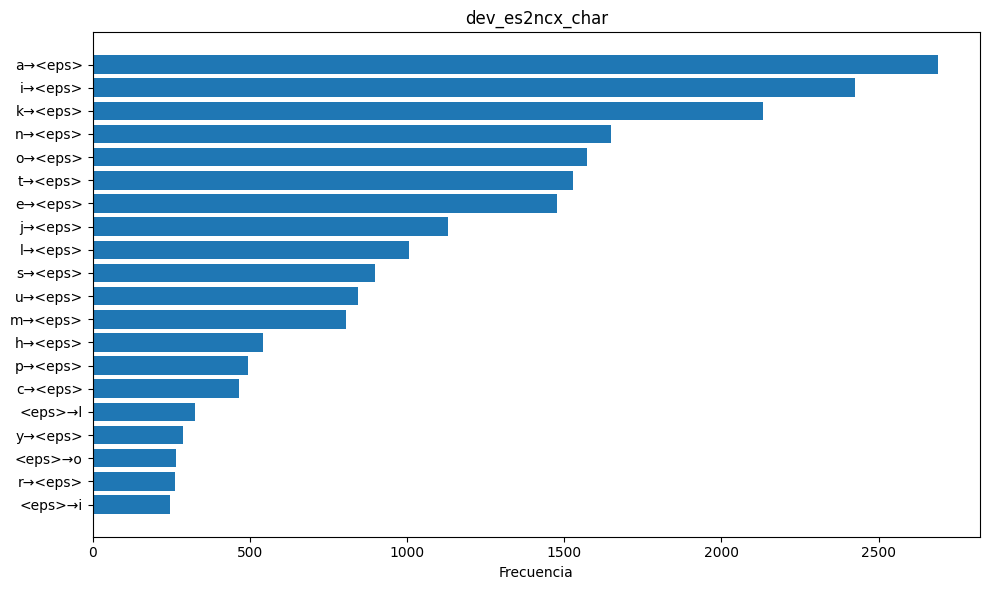

Guardado: /content/logs/analytics/plots/confusion_plot_dev_es2ncx_char.png


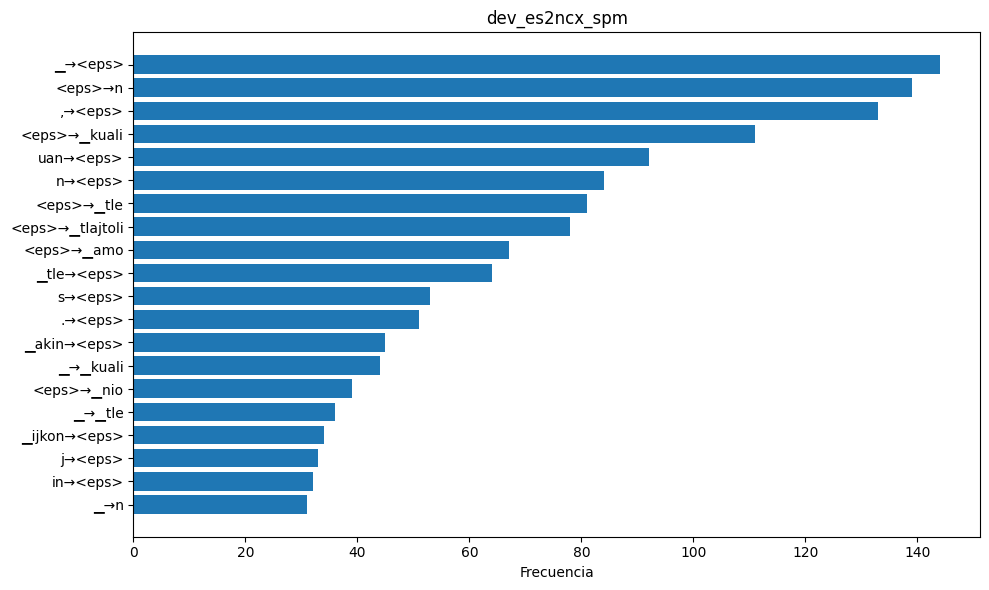

Guardado: /content/logs/analytics/plots/confusion_plot_dev_es2ncx_spm.png


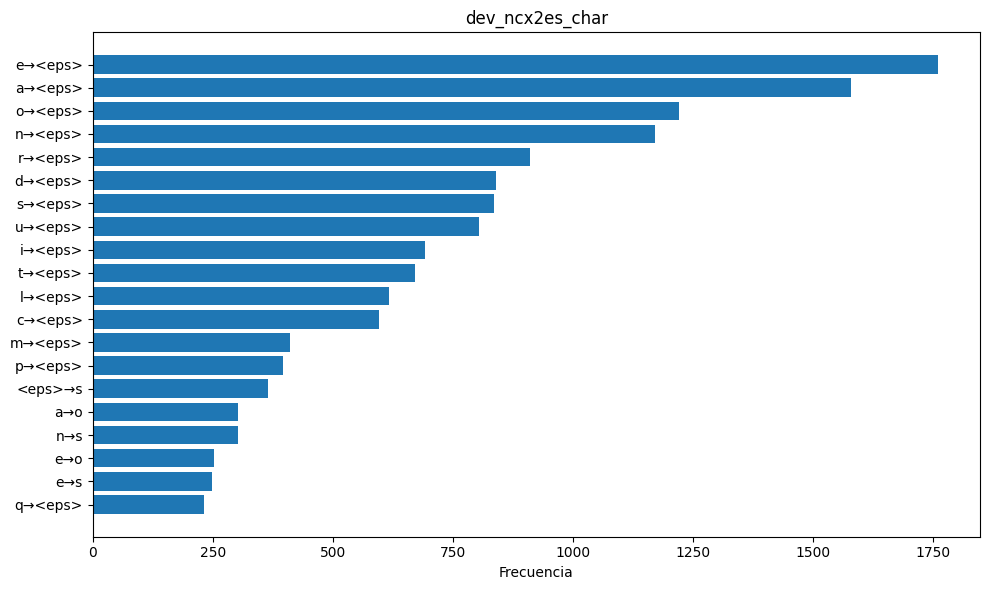

Guardado: /content/logs/analytics/plots/confusion_plot_dev_ncx2es_char.png


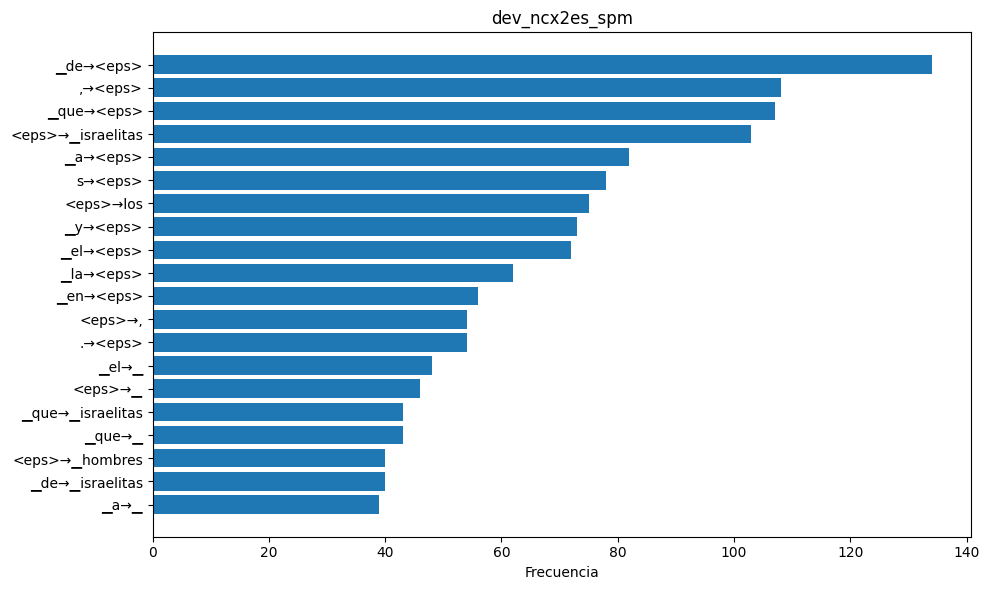

Guardado: /content/logs/analytics/plots/confusion_plot_dev_ncx2es_spm.png


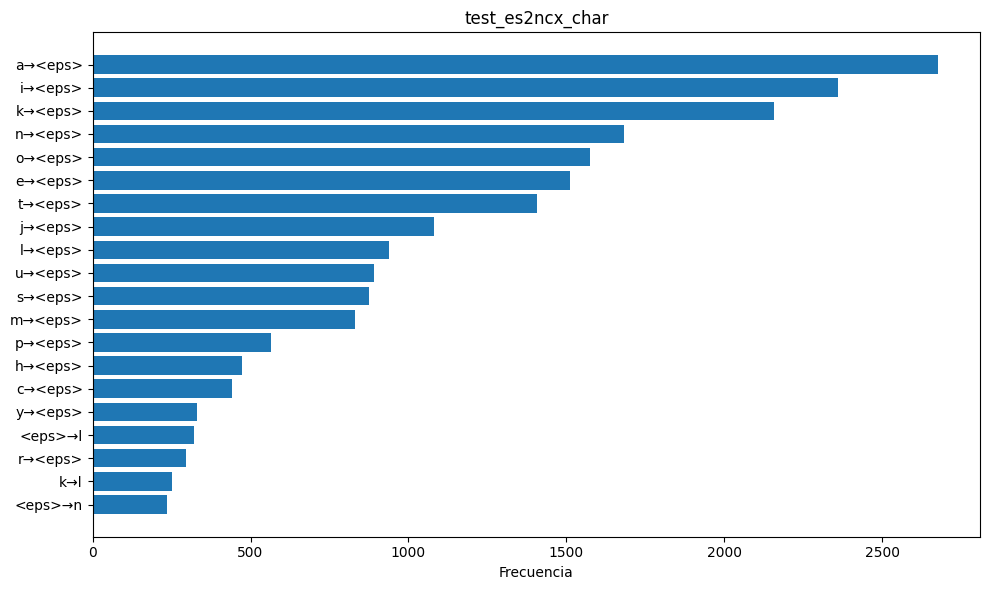

Guardado: /content/logs/analytics/plots/confusion_plot_test_es2ncx_char.png


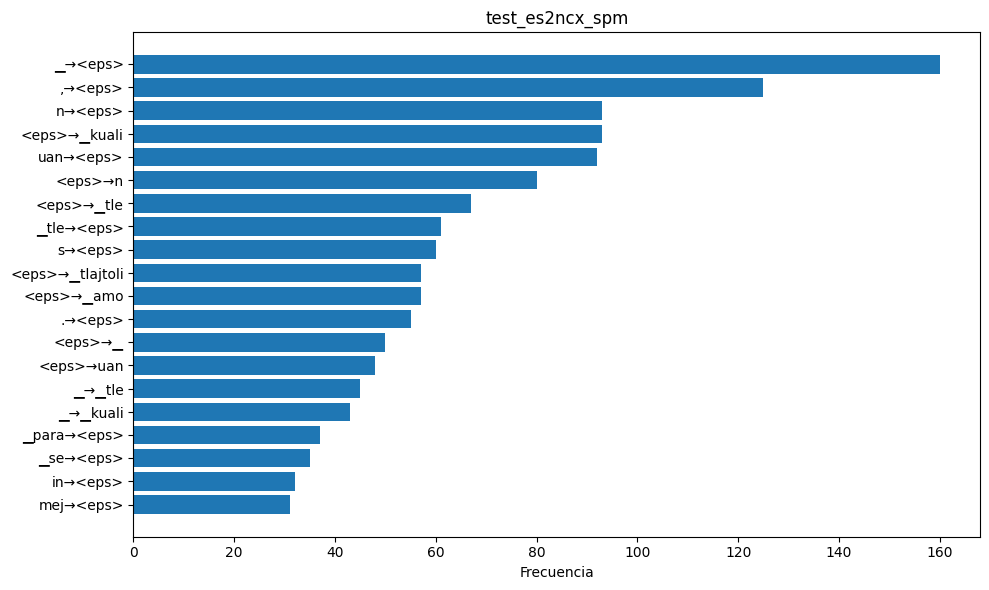

Guardado: /content/logs/analytics/plots/confusion_plot_test_es2ncx_spm.png


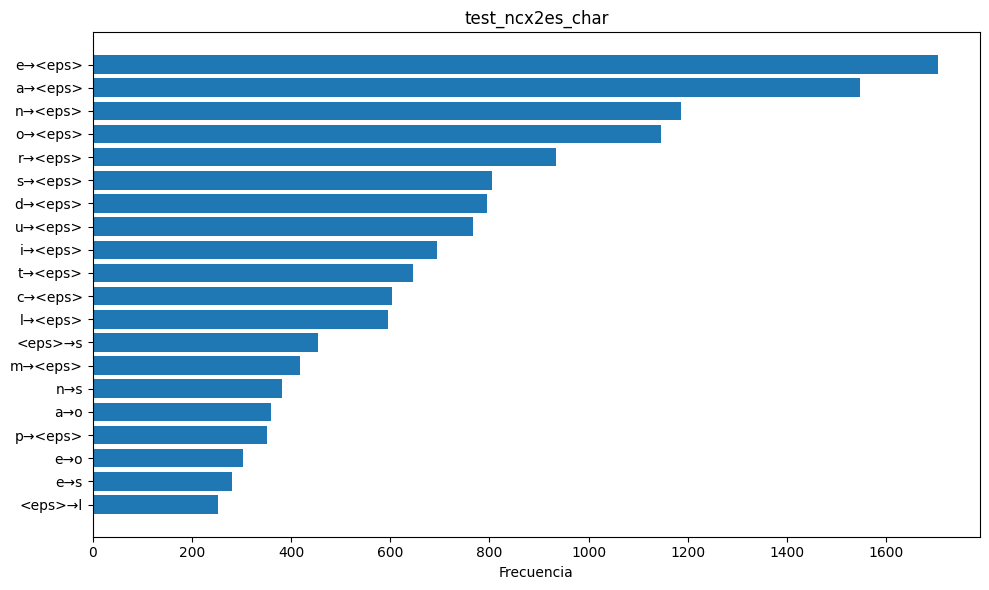

Guardado: /content/logs/analytics/plots/confusion_plot_test_ncx2es_char.png


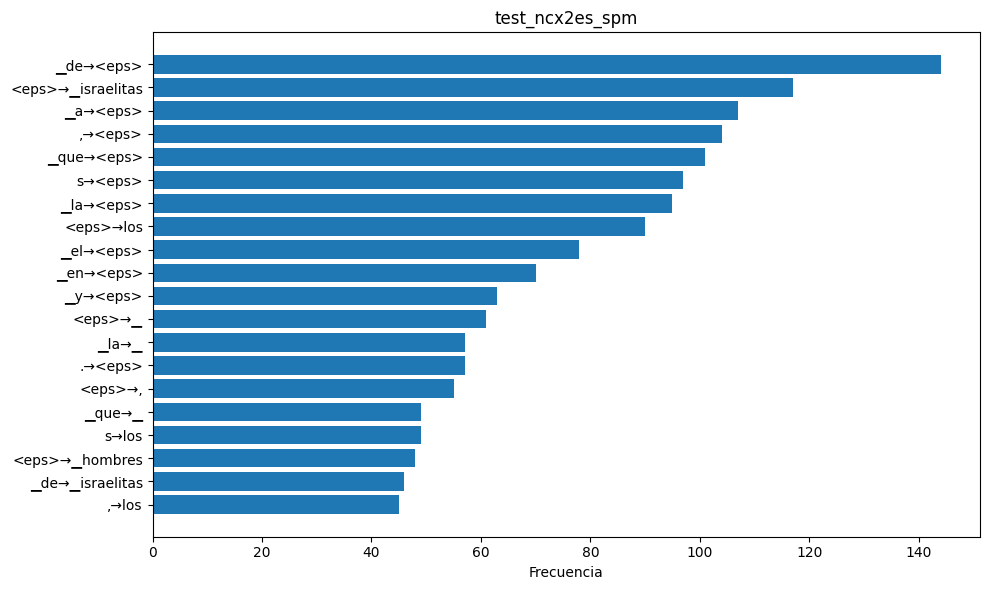

Guardado: /content/logs/analytics/plots/confusion_plot_test_ncx2es_spm.png


['/content/logs/analytics/plots/confusion_plot_dev_es2ncx_char.png',
 '/content/logs/analytics/plots/confusion_plot_dev_es2ncx_spm.png',
 '/content/logs/analytics/plots/confusion_plot_dev_ncx2es_char.png',
 '/content/logs/analytics/plots/confusion_plot_dev_ncx2es_spm.png',
 '/content/logs/analytics/plots/confusion_plot_test_es2ncx_char.png',
 '/content/logs/analytics/plots/confusion_plot_test_es2ncx_spm.png',
 '/content/logs/analytics/plots/confusion_plot_test_ncx2es_char.png',
 '/content/logs/analytics/plots/confusion_plot_test_ncx2es_spm.png']

In [34]:
# 18) Visualización de confusiones (Top-20)
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

ANALYTICS_DIR = (LOG_DIR / "analytics").as_posix()
PLOT_DIR = (LOG_DIR / "analytics" / "plots").as_posix()
Path(PLOT_DIR).mkdir(parents=True, exist_ok=True)

def list_top_pair_csvs():
    pattern = os.path.join(ANALYTICS_DIR, "top_pairs_*.csv")
    files = sorted(glob.glob(pattern))
    print(f"Encontrados {len(files)} archivos top_pairs_*.csv")
    return files

def plot_top20(csv_path, top_k=20):
    df = pd.read_csv(csv_path)
    if "count" not in df.columns:
        print("CSV sin columna 'count':", csv_path); return None
    df2 = df.sort_values("count", ascending=False).head(top_k)
    labels = [f"{r}→{h}" for r, h in zip(df2["ref"], df2["hyp"])]
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(df2)), df2["count"].values)
    plt.yticks(range(len(df2)), labels)
    plt.gca().invert_yaxis()
    plt.xlabel("Frecuencia")
    plt.title(os.path.basename(csv_path).replace("top_pairs_", "").replace(".csv",""))
    plt.tight_layout()
    out_png = os.path.join(PLOT_DIR, "confusion_plot_" + os.path.basename(csv_path).replace("top_pairs_", "").replace(".csv",".png"))
    plt.savefig(out_png, dpi=150)
    plt.show()
    print("Guardado:", out_png)
    return out_png

def generate_all_top20_plots():
    outs = []
    for f in list_top_pair_csvs():
        out = plot_top20(f, top_k=20)
        if out: outs.append(out)
    return outs

# Descomenta para generar las gráficas una vez tengas CSVs:
generate_all_top20_plots()
